In [2]:
import os
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import keras

# 1. Load dataset

In [3]:
# Path to the dataset
dataset_dir = 'dataset/coil-100'

# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            label = int(filename.split('__')[0][3:]) - 1  # Extract label from filename
            labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images_from_folder(dataset_dir)

# 2. Prepare dataset

In [4]:
# Normalize images 
images = images / 255.0
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Further split the training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [6]:
import keras_tuner as kt
from keras import layers, models
from keras.optimizers import Adam

def build_model(learning_rate):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(100, activation='softmax')
    ])
    
    # Compile the model with the learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.0016729, 0.0001, 0.01],
    'batch_size': [8, 16, 32],
}

# Iterate over the hyperparameter grid
best_acc = 0
best_params = None
best_history = None
best_model = None

for lr in param_grid['learning_rate']:
    for batch_size in param_grid['batch_size']:
        print(f"Training with learning_rate={lr}, batch_size={batch_size}")
        
        # Build the model
        model = build_model(learning_rate=lr)
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val, y_val))
        
        # Evaluate the model
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f"Test accuracy: {test_acc}")
        
        # Track the best model based on validation accuracy
        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'learning_rate': lr, 'batch_size': batch_size}
            best_history = history
            best_model = model

print(f"Best Hyperparameters: {best_params}")
print(f"Best Test Accuracy: {best_acc}")

Training with learning_rate=0.0016729, batch_size=8
Epoch 1/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.1716 - loss: 3.7311 - val_accuracy: 0.8368 - val_loss: 0.5712
Epoch 2/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.7354 - loss: 0.9022 - val_accuracy: 0.9444 - val_loss: 0.2049
Epoch 3/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8388 - loss: 0.5140 - val_accuracy: 0.9358 - val_loss: 0.2015
Epoch 4/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8801 - loss: 0.3651 - val_accuracy: 0.9705 - val_loss: 0.0818
Epoch 5/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9048 - loss: 0.3032 - val_accuracy: 0.9722 - val_loss: 0.0611
Epoch 6/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9176 - loss: 0.2664 - val_accuracy: 0.9861 - val_loss: 0.0488
Epoch 7/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9234 - loss: 0.2418 - val_accuracy: 0.9844 - val_loss: 0.0574
Epoch 8/20
648/648 ━━━━━━━━━━━━━━━━━━━

Train accuracy: 0.9718364477157593
Train loss: 0.08466453105211258
Val accuracy: 0.9982638955116272
Val loss: 0.006558573339134455


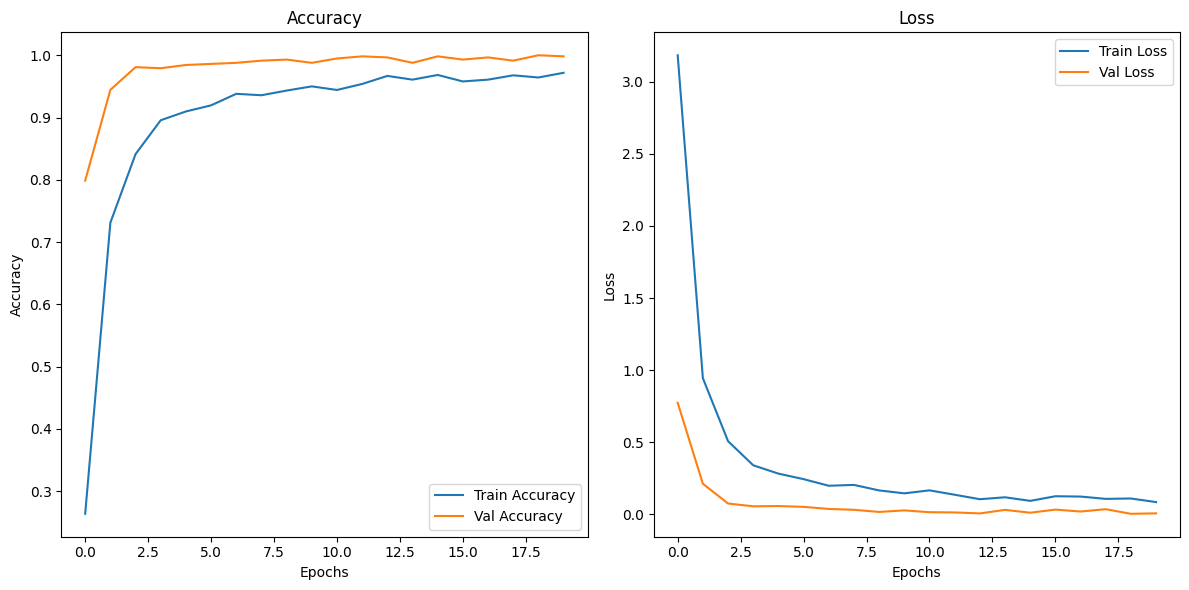

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Best model: learning rate = 0.0016729, batch_size = 32
print(f"Train accuracy: {best_history.history['accuracy'][-1]}")
print(f"Train loss: {best_history.history['loss'][-1]}")
print(f"Val accuracy: {best_history.history['val_accuracy'][-1]}")
print(f"Val loss: {best_history.history['val_loss'][-1]}")
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Precision: 0.9970
Recall: 0.9965
F1 Score: 0.9965


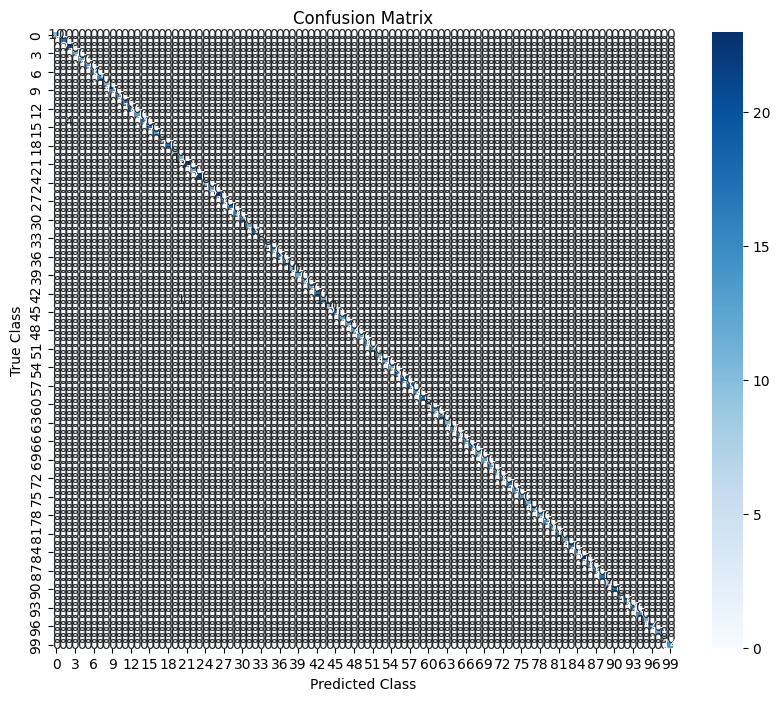

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on the test dataset
y_pred = best_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print the scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Optional: Plot a confusion matrix for additional insight
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()